In [1]:
# --- Imports ---
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score, mean_squared_error
import joblib

# %%
# --- Config / Paths ---
DATA_PATH = Path('D:\AA 2025\Data_Science_projects\Pharma_sales.csv')  # change if your CSV is elsewhere
MODEL_OUT = Path('D:\AA 2025\Data_Science_projects\pharma_lasso_model.pkl')
RANDOM_STATE = 42
TEST_SIZE = 0.3

In [2]:
def load_data(path: Path) -> pd.DataFrame:
    """Load CSV and perform light validation."""
    if not path.exists():
        raise FileNotFoundError(f"Data file not found: {path.resolve()}")
    df = pd.read_csv(path)
    print(f"Loaded {len(df)} rows and {len(df.columns)} columns from {path}")
    return df

In [3]:
def basic_eda(df: pd.DataFrame, show_plots: bool = True):
    """
     basic EDA:
    - Shows info and numeric description.
    - Plots histograms for numeric columns (if not too many).
    - Computes correlation only on numeric columns and draws a heatmap.
    """
    print('\n--- Data Info ---')
    print(df.info())

    print('\n--- Description (numerical) ---')
    display(df.describe().T)

    # Separate numeric and non-numeric cols
    numeric_df = df.select_dtypes(include=[np.number])
    non_numeric_cols = [c for c in df.columns if c not in numeric_df.columns]

    if non_numeric_cols:
        print(f"\nNote: these non-numeric columns were excluded from numeric plots/correlations: {non_numeric_cols}")

    if not show_plots:
        return

    # Histograms: only if <= 6 numeric cols (avoid crazy wide layouts)
    num_cols = numeric_df.columns.tolist()
    if num_cols:
        if len(num_cols) <= 6:
            figsize = (4 * len(num_cols), 4)
            numeric_df.hist(bins=20, figsize=figsize)
            plt.tight_layout()
            plt.show()
        else:
            # summary hist: show first 6 numeric cols to inspect distributions
            print(f"\nToo many numeric cols ({len(num_cols)}). Showing histograms for the first 6 numeric columns:")
            numeric_df[num_cols[:6]].hist(bins=20, figsize=(4 * 6, 4))
            plt.tight_layout()
            plt.show()
    else:
        print("\nNo numeric columns found for histogram plotting.")

    # Correlation heatmap only on numeric cols
    if numeric_df.shape[1] >= 2:
        corr = numeric_df.corr()
        plt.figure(figsize=(8, 6))
        sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
        plt.title('Correlation matrix (numeric columns only)')
        plt.show()
    else:
        print("\nNot enough numeric columns to compute a correlation matrix.")

In [4]:
# --- Preprocessing ---

def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Example: drop completely empty columns
    df = df.dropna(axis=1, how='all')

    # Example: fill small missing numeric values with median
    num_cols = df.select_dtypes(include=[np.number]).columns
    for c in num_cols:
        if df[c].isna().sum() > 0:
            df[c] = df[c].fillna(df[c].median())



    return df

In [5]:
# --- Modeling pipeline (Lasso) ---

def train_lasso(X, y, random_state=RANDOM_STATE):
    """Train Lasso using GridSearch over alpha values and return best model + CV results."""
    alphas = np.logspace(-3, 0, 50)
    param_grid = {'alpha': alphas}
    lasso = Lasso(max_iter=10000, random_state=random_state)
    gs = GridSearchCV(lasso, param_grid, scoring='r2', cv=5, n_jobs=-1)
    gs.fit(X, y)
    print(f"Best alpha: {gs.best_params_['alpha']}")
    return gs

In [6]:
# --- Evaluation utils ---

def evaluate_model(model, X_train, X_test, y_train, y_test):
    """Print common regression metrics and show residual plot."""
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)

    print(f"Train R²: {train_r2:.4f}")
    print(f"Test R²:  {test_r2:.4f}")
    print(f"Test RMSE: {rmse_test:.4f}")

    # Residual plot
    plt.figure(figsize=(6, 4))
    plt.scatter(y_pred_test, y_test - y_pred_test)
    plt.axhline(0, color='k', linestyle='--')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Predicted')
    plt.show()

Loaded 500 rows and 7 columns from D:\AA 2025\Data_Science_projects\Pharma_sales.csv

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   HCP_Email_Account    500 non-null    object 
 1   HCP_Account_Address  500 non-null    object 
 2   SF_Detailing_min     500 non-null    float64
 3   Website_Link_Clicks  500 non-null    float64
 4   Adv_Views_Sec        500 non-null    float64
 5   HCP_PDE              500 non-null    float64
 6   Sales                500 non-null    float64
dtypes: float64(5), object(2)
memory usage: 27.5+ KB
None

--- Description (numerical) ---


,count,mean,std,min,25%,50%,75%,max
SF_Detailing_min,500.0,33.053194,0.992563,29.532429,32.341822,33.082008,33.711985,36.139662
Website_Link_Clicks,500.0,12.052488,0.994216,8.508152,11.388153,11.983231,12.753850,15.126994
Adv_Views_Sec,500.0,37.060445,1.010489,33.913847,36.349257,37.069367,37.716432,40.005182
HCP_PDE,500.0,3.533462,0.999278,0.269901,2.930450,3.533975,4.126502,6.922689
Sales,500.0,499.314038,79.314782,256.670582,445.038277,498.887875,549.313828,765.518462



Note: these non-numeric columns were excluded from numeric plots/correlations: ['HCP_Email_Account', 'HCP_Account_Address']


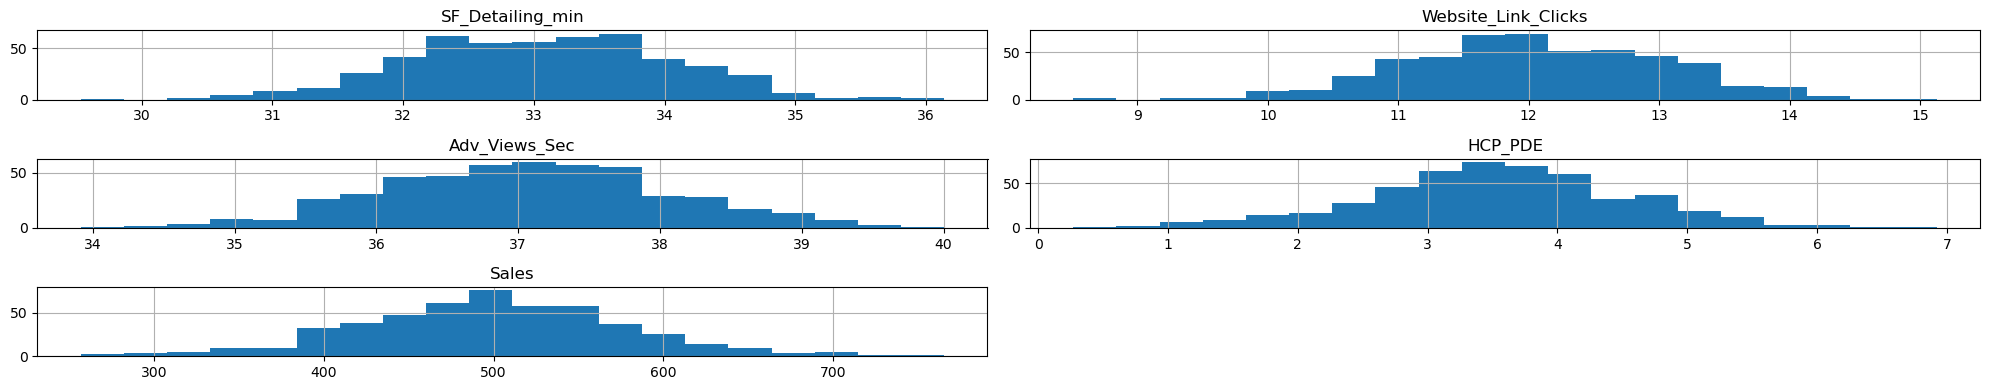

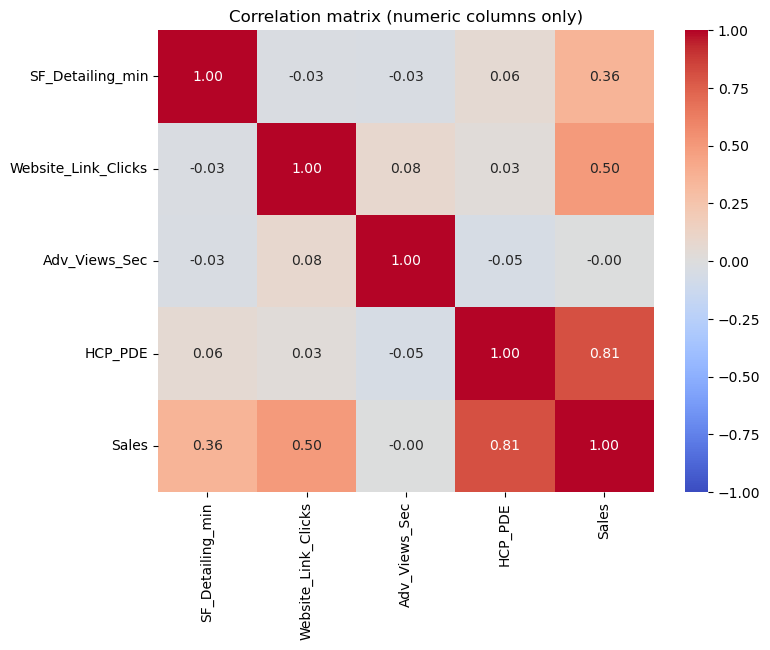

Best alpha: 0.0517947467923121
Train R²: 0.9854
Test R²:  0.9809
Test RMSE: 10.1942


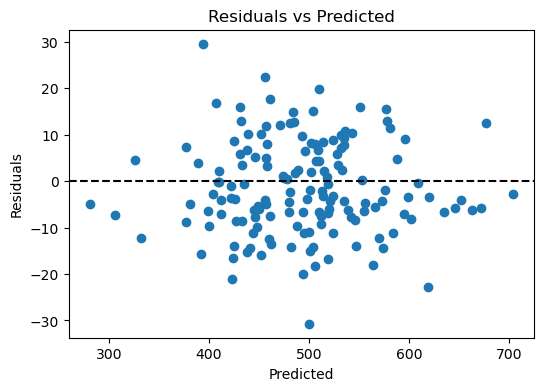


Feature coefficients:


,feature,coefficient
3,HCP_PDE,61.627845
1,Website_Link_Clicks,38.551234
0,SF_Detailing_min,25.673858
2,Adv_Views_Sec,0.411260


Saved trained model to: D:\AA 2025\Data_Science_projects\pharma_lasso_model.pkl


In [7]:
# --- Main: tie everything together ---

def main(data_path: Path = DATA_PATH):
    # Load
    df = load_data(data_path)

    # Quick EDA
    basic_eda(df)

    # Preprocess
    df_clean = preprocess(df)


    FEATURES = ['SF_Detailing_min', 'Website_Link_Clicks', 'Adv_Views_Sec', 'HCP_PDE']
    TARGET = 'Sales'

    missing = [c for c in FEATURES + [TARGET] if c not in df_clean.columns]
    if missing:
        raise KeyError(f"Expected columns not found in data: {missing}")

    X = df_clean[FEATURES]
    y = df_clean[TARGET]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

    # Train Lasso via GridSearchCV
    gs = train_lasso(X_train, y_train)

    # Evaluate best model
    best_model = gs.best_estimator_
    evaluate_model(best_model, X_train, X_test, y_train, y_test)

    # Show top coefficients as a DataFrame
    coef_df = pd.DataFrame({'feature': FEATURES, 'coefficient': best_model.coef_})
    coef_df = coef_df.sort_values(by='coefficient', key=lambda s: s.abs(), ascending=False)
    print('\nFeature coefficients:')
    display(coef_df)

    # Save model
    joblib.dump(best_model, MODEL_OUT)
    print(f"Saved trained model to: {MODEL_OUT.resolve()}")

# %%
# Run when executed as a script
if __name__ == '__main__':
    main()
